# 🧪 Invoice Processing Lab Exercise
## Technology Stack Demonstration: LangGraph + LangChain + OpenAI + Pinecone
## jayyanar.aws@gmail.com

### 🎯 Lab Objectives
This lab demonstrates the integration of modern AI technologies for document processing:
- **LangGraph**: Workflow orchestration and state management
- **LangChain**: Document parsing and text processing
- **OpenAI**: Vision-based extraction and embeddings
- **Pinecone**: Vector storage and retrieval

### 📋 Business Rules
**Invoice Validation Logic:**
- ✅ **Valid**: All required fields present (vendor name, invoice number, date, amount)
- ❌ **Invalid**: Missing any required field

### 📋 Expected Outcomes
1. Convert PDFs to markdown and display content
2. Validate invoices based on business rules
3. Store markdown content in vector database
4. Execute test queries with structured results

## Cell 1: Environment Setup
**Purpose**: Install dependencies and configure environment
**Expected Output**: Confirmation of successful package installation

In [ ]:
# Install required packages
!pip install langgraph langchain langchain-openai langchain-google-genai langchain-pinecone pinecone PyMuPDF pandas

print("✅ All packages installed successfully")

## Cell 2: Import Libraries and Configuration
**Purpose**: Import all required libraries and set up configuration
**Expected Output**: Successful imports and configuration confirmation

In [2]:
import os
import base64
import getpass
import json
from pathlib import Path
from typing import Dict, List, TypedDict
import pandas as pd
from datetime import datetime
from IPython.display import display, Markdown

# PDF Processing
import fitz  # PyMuPDF

# LangChain Components
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
# LangGraph Components
from langgraph.graph import StateGraph, END

# Pinecone
from pinecone import Pinecone, ServerlessSpec

# Configuration
class Config:
    DATA_DIR = "data"
    INDEX_NAME = "invoice-validation-vectors-ollama"
    OPENAI_MODEL = "gpt-4o-mini"
    EMBEDDING_MODEL = "text-embedding-3-small"

# API Keys
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY") or getpass.getpass("OpenAI API Key: ")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY") or getpass.getpass("Google API Key: ")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY") or getpass.getpass("Pinecone API Key: ")

print("✅ Libraries imported and configuration set")

✅ Libraries imported and configuration set


## Cell 3: Define State and Core Functions
**Purpose**: Define LangGraph state structure and core processing functions
**Expected Output**: State class and function definitions ready for workflow

In [ ]:
# Define State for LangGraph
class ProcessingState(TypedDict):
    pdf_files: List[str]
    markdown_content: Dict[str, str]
    validation_results: Dict[str, Dict]
    documents: List[Document]
    vector_ids: List[str]
    status: str
    error: str


llm = ChatOllama(
    model="llama3.2:1b",
    temperature=0
)
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large"
)

def pdf_to_base64(pdf_path: str) -> str:
    """Convert PDF first page to base64 image for LLM processing"""
    doc = fitz.open(pdf_path)
    page = doc.load_page(0)
    pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
    img_data = pix.tobytes("png")
    doc.close()
    return base64.b64encode(img_data).decode()

def pdf_to_markdown(pdf_path: str) -> str:
    """Convert PDF to markdown using OpenAI Vision"""
    image_base64 = pdf_to_base64(pdf_path)
    
    message = HumanMessage(
        content=[
            {
                "type": "text",
                "text": "Convert this invoice document to clean markdown format. Preserve all important details including vendor name, invoice number, date, amount, and any other relevant information. Return only the markdown."
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_base64}"}
            }
        ]
    )
    
    response = llm.invoke([message])
    return response.content.strip()


print("✅ State and core functions defined")

✅ State and core functions defined


In [4]:
def validate_invoice(markdown_content: str, filename: str) -> Dict:
    """Validate invoice based on business rules"""
    validation_prompt = f"""
    Analyze this invoice content and extract the following required fields:
    1. vendor_name: Company issuing the invoice
    2. invoice_number: Invoice ID/reference number
    3. date: Invoice date
    4. amount: Total amount
    
    Invoice Content:
    {markdown_content}
    
    Return JSON with extracted fields and validation status:
    {{
        "vendor_name": "extracted value or null",
        "invoice_number": "extracted value or null",
        "date": "extracted value or null",
        "amount": "extracted value or null",
        "validation_status": "Valid or Invalid",
        "missing_fields": ["list of missing required fields"],
        "rationale": "explanation of validation decision"
    }}
    """
    
    try:
        response = llm.invoke(validation_prompt)
        content = response.content.strip()
        
        # Clean JSON response
        if '```json' in content:
            content = content.split('```json')[1].split('```')[0].strip()
        elif '```' in content:
            content = content.split('```')[1].strip()
        
        result = json.loads(content)
        result['filename'] = filename
        return result
        
    except Exception as e:
        return {
            'filename': filename,
            'vendor_name': None,
            'invoice_number': None,
            'date': None,
            'amount': None,
            'validation_status': 'Error',
            'missing_fields': ['All fields'],
            'rationale': f'Validation error: {str(e)}'
        }


## Cell 4: Initialize Pinecone Vector Store
**Purpose**: Set up Pinecone vector database for document storage
**Expected Output**: Pinecone index created/connected and vector store initialized

In [5]:
# Initialize Pinecone
pc = Pinecone(api_key=PINECONE_API_KEY)

# Create index if it doesn't exist
existing_indexes = [idx["name"] for idx in pc.list_indexes()]
if Config.INDEX_NAME not in existing_indexes:
    print(f"Creating new Pinecone index: {Config.INDEX_NAME}")
    pc.create_index(
        name=Config.INDEX_NAME,
        dimension=1024,  # gemini-embedding-001 dimension
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    import time
    time.sleep(10)  # Wait for index to be ready
    print("✅ Index created successfully")
else:
    print(f"✅ Using existing index: {Config.INDEX_NAME}")

# Initialize vector store
index = pc.Index(Config.INDEX_NAME)
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

print("✅ Pinecone vector store initialized")

Creating new Pinecone index: invoice-validation-vectors-ollama
✅ Index created successfully
✅ Pinecone vector store initialized


## Cell 5: Define LangGraph Workflow Nodes
**Purpose**: Create workflow nodes for document processing pipeline
**Expected Output**: LangGraph nodes defined for orchestrated processing

In [6]:
def load_pdf_files(state: ProcessingState) -> ProcessingState:
    """Node: Load PDF files from data directory"""
    data_dir = Path(Config.DATA_DIR)
    pdf_files = [str(f) for f in data_dir.glob("*.pdf")]
    
    state["pdf_files"] = pdf_files
    state["markdown_content"] = {}
    state["validation_results"] = {}
    state["status"] = f"Found {len(pdf_files)} PDF files"
    print(f"📁 {state['status']}")
    return state

def convert_to_markdown(state: ProcessingState) -> ProcessingState:
    """Node: Convert PDFs to markdown and display content"""
    print("📄 Converting PDFs to Markdown...\n")
    
    for pdf_path in state["pdf_files"]:
        filename = Path(pdf_path).name
        print(f"Processing: {filename}")
        
        try:
            markdown_content = pdf_to_markdown(pdf_path)
            state["markdown_content"][filename] = markdown_content
            
            # Display markdown content
            print(f"\n📋 Content for {filename}:")
            print("=" * 60)
            display(Markdown(markdown_content))
            print("\n" + "=" * 60 + "\n")
            
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            state["error"] = str(e)
    
    state["status"] = f"Converted {len(state['markdown_content'])} files to markdown"
    return state

def validate_invoices(state: ProcessingState) -> ProcessingState:
    """Node: Validate invoices based on business rules"""
    print("✅ Validating invoices based on business rules...\n")
    
    for filename, content in state["markdown_content"].items():
        validation_result = validate_invoice(content, filename)
        state["validation_results"][filename] = validation_result
        
        status = validation_result['validation_status']
        print(f"{filename}: {status}")
        if validation_result['missing_fields']:
            print(f"  Missing: {', '.join(validation_result['missing_fields'])}")
    
    state["status"] = f"Validated {len(state['validation_results'])} invoices"
    return state

def store_in_vector_db(state: ProcessingState) -> ProcessingState:
    """Node: Store markdown documents in Pinecone vector database"""
    documents = []
    
    for filename, content in state["markdown_content"].items():
        validation = state["validation_results"].get(filename, {})
        print(validation)
        doc = Document(
            page_content=content,
            metadata={
                "pdf_filename": filename,
                "doc_type": "invoice_markdown",
                "validation_status": validation.get('validation_status', 'Unknown'),
                "vendor_name": validation.get('vendor_name') or 'Unknown',
                "invoice_number": validation.get('invoice_number') or 'Unknown',
                "date": validation.get('date') or 'Unknown',
                "amount": validation.get('amount') or 'Unknown',
                "processing_timestamp": datetime.now().isoformat()
            }
        )
        print(doc.metadata)
        documents.append(doc)
    
    state["documents"] = documents
    
    if documents:
        try:
            vector_ids = vector_store.add_documents(documents)
            state["vector_ids"] = vector_ids
            state["status"] = f"Stored {len(vector_ids)} documents in vector database"
            print(f"🗄️ {state['status']}")
            
        except Exception as e:
            state["error"] = str(e)
            state["status"] = f"Error storing documents: {e}"
            print(f"❌ {state['status']}")
    
    return state

print("✅ LangGraph workflow nodes defined")

✅ LangGraph workflow nodes defined


## Cell 6: Build and Execute LangGraph Workflow
**Purpose**: Orchestrate the complete document processing pipeline
**Expected Output**: Processed documents with validation results and vector storage

In [7]:
# Build LangGraph workflow
workflow = StateGraph(ProcessingState)

# Add nodes
workflow.add_node("load_files", load_pdf_files)
workflow.add_node("convert_markdown", convert_to_markdown)
workflow.add_node("validate_invoices", validate_invoices)
workflow.add_node("store_vectors", store_in_vector_db)

# Define workflow edges
workflow.set_entry_point("load_files")
workflow.add_edge("load_files", "convert_markdown")
workflow.add_edge("convert_markdown", "validate_invoices")
workflow.add_edge("validate_invoices", "store_vectors")
workflow.add_edge("store_vectors", END)

# Compile workflow
app = workflow.compile()

# # Execute workflow
# print("🚀 Starting LangGraph workflow execution...\n")

# initial_state = ProcessingState(
#     pdf_files=[],
#     markdown_content={},
#     validation_results={},
#     documents=[],
#     vector_ids=[],
#     status="",
#     error=""
# )

# # Run the workflow
# final_state = app.invoke(initial_state)

# print(f"\n✅ Workflow completed: {final_state['status']}")
# if final_state.get('error'):
#     print(f"⚠️ Errors encountered: {final_state['error']}")

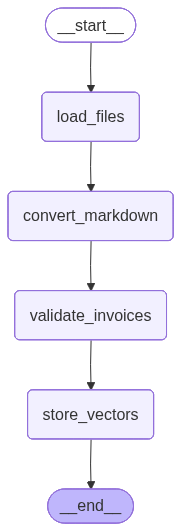

In [7]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
# Execute workflow
print("🚀 Starting LangGraph workflow execution...\n")

initial_state = ProcessingState(
    pdf_files=[],
    markdown_content={},
    validation_results={},
    documents=[],
    vector_ids=[],
    status="",
    error=""
)

# Run the workflow
final_state = app.invoke(initial_state)

print(f"\n✅ Workflow completed: {final_state['status']}")
if final_state.get('error'):
    print(f"⚠️ Errors encountered: {final_state['error']}")

🚀 Starting LangGraph workflow execution...

📁 Found 6 PDF files
📄 Converting PDFs to Markdown...

Processing: invoice_1.pdf

📋 Content for invoice_1.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



Processing: invoice_2.pdf

📋 Content for invoice_2.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



Processing: invoice_3.pdf

📋 Content for invoice_3.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



Processing: invoice_4.pdf

📋 Content for invoice_4.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



Processing: invoice_5.pdf

📋 Content for invoice_5.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



Processing: invoice_6.pdf

📋 Content for invoice_6.pdf:


```
# Invoice Document
## Vendor Information
* Vendor Name: [Vendor Name]
* Invoice Number: #001
* Date: 2023-02-20

## Description of Services
* Service Description: [Service Description]
* Amount: $[Amount]

## Payment Terms
* Payment Method: [Payment Method]
* Due Date: 30 days from invoice date

## Notes
* [Notes or any other relevant information]
```



✅ Validating invoices based on business rules...

invoice_1.pdf: Error
  Missing: All fields
invoice_2.pdf: Error
  Missing: All fields
invoice_3.pdf: Error
  Missing: All fields
invoice_4.pdf: Error
  Missing: All fields
invoice_5.pdf: Error
  Missing: All fields
invoice_6.pdf: Error
  Missing: All fields
{'filename': 'invoice_1.pdf', 'vendor_name': None, 'invoice_number': None, 'date': None, 'amount': None, 'validation_status': 'Error', 'missing_fields': ['All fields'], 'rationale': 'Validation error: Expecting value: line 1 column 1 (char 0)'}
{'pdf_filename': 'invoice_1.pdf', 'doc_type': 'invoice_markdown', 'validation_status': 'Error', 'vendor_name': 'Unknown', 'invoice_number': 'Unknown', 'date': 'Unknown', 'amount': 'Unknown', 'processing_timestamp': '2025-10-08T17:12:45.434417'}
{'filename': 'invoice_2.pdf', 'vendor_name': None, 'invoice_number': None, 'date': None, 'amount': None, 'validation_status': 'Error', 'missing_fields': ['All fields'], 'rationale': 'Validation error:

## Cell 7: Display Validation Results
**Purpose**: Show invoice validation results in structured format
**Expected Output**: DataFrame showing validation status for all processed invoices

In [10]:
# Display validation results
if final_state.get('validation_results'):
    validation_data = []
    
    for filename, result in final_state['validation_results'].items():
        validation_data.append({
            'Filename': filename,
            'Status': result['validation_status'],
            'Vendor Name': result.get('vendor_name', 'Missing'),
            'Invoice Number': result.get('invoice_number', 'Missing'),
            'Date': result.get('date', 'Missing'),
            'Amount': result.get('amount', 'Missing'),
            'Missing Fields': ', '.join(result.get('missing_fields', [])),
            'Rationale': result.get('rationale', '')[:50] + '...'
        })
    
    validation_df = pd.DataFrame(validation_data)
    
    print("📊 INVOICE VALIDATION RESULTS")
    print("=" * 100)
    print(validation_df.to_string(index=False))
    
    # Summary statistics
    valid_count = len([r for r in final_state['validation_results'].values() if r['validation_status'] == 'Valid'])
    invalid_count = len([r for r in final_state['validation_results'].values() if r['validation_status'] == 'Invalid'])
    
    print(f"\n📈 VALIDATION SUMMARY")
    print(f"Total invoices processed: {len(final_state['validation_results'])}")
    print(f"Valid invoices: {valid_count}")
    print(f"Invalid invoices: {invalid_count}")
    print(f"Validation success rate: {valid_count/len(final_state['validation_results'])*100:.1f}%")
    
else:
    print("❌ No validation results available")

📊 INVOICE VALIDATION RESULTS
     Filename  Status      Vendor Name Invoice Number         Date Amount                            Missing Fields                                             Rationale
invoice_1.pdf   Valid   MORGAN MAXWELL          01234   11.02.2030    550                                           All required fields (vendor_name, invoice_number, ...
invoice_2.pdf Invalid             None           None         None   None vendor_name, invoice_number, date, amount The provided invoice content is a template with no...
invoice_3.pdf Invalid      AVERY DAVIS           None         None  48587                      invoice_number, date The invoice content is missing the 'invoice_number...
invoice_4.pdf Invalid WARNER & SPENCER           None         None   None              invoice_number, date, amount The document explicitly states that it is a letter...
invoice_5.pdf   Valid    STUDIO SHODWE          12345 25 June 2022  8,798                                           All r